# Pairs Trading

This trading strategy is based upon mathematical analysis, it states that is you have a pair of assets $X$ and $Y$ that have some undelying economic link, for example two companies that manufacture the same product, said economic link can be represented with a methematical model upon which we can make trades.

## Cointegration

Cointegration is the fundamental way in which we will find these pairs of assets, therefore we must exlain what cointegration is. 

We will start by defining a stationary process, we say something is stationary in the wide sense when it's joint probability distribution does not change when shifted in time, meaning that variables such as mean and variance will be constant over time, this is relevant, because most statistical tests assume stationarity, and therefore not having stationary data could lead to results that are not useful, or even worse could result in errors. An example of this is the use of the mean of a series as a prediction for future behaviour; in a stationary series the means does an okay job at predictiong future values, not great but useful, while the mean of a non-stationary function tells us nothing about its future behaviour. In order to test for stationarity we use $p-values$ acording to the augmented Dickey-Fuller test. In gneral a $p-value$ of less than 5% means the null hypothesis can be rejected (the null hypothesis being that the data are non-stationary).

There is another important definition that must be made before we go on to explain what cointegrations is, and that would be what the orders of integration are. The fist order of integration is $I(0)$, this order of integration is really hard to test for given any slightly large dataset, but any stationary process has an integration order of 0. In order to get a series with an order of integration of 1, what must be done is take an $I(0)$ series and use discrete integration on it (which would be to commulatively sum it). And so on, in order to get an $I(2)$ series we use discrete integration on a $I(1)$ series, and to get an $I(3)$ series we commulatively sun an $I(2)$ series.

Now, finally, for some set of time series $(X_1, X_2, ..., X_k)$ if all the time series are $I(1)$ and there is a linear combination of them that is $I(0)$, then we can say that this set of time series is cointegrated. Intitively we can state that there is cointegration between two series if their difference is mean reverting, which means that it is centered around and hovers around the mean of the series abtaining by substracting the two cointegrated series. For more specific purposes, we will use the Engle-Granger two-step cointegration test foind in the *statsmodels* python library. This is the base of pairs trading, because if we find two assets with cointegrated price-time series, we have reason to believe that there is a relyable economic link betwen these two assets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import datetime
from datetime import timedelta

# Finding Assets with Cointegrated Prices

In order to do this we will takje a two step approach. In order to avoid the multiple comparison bias, we will begin by defining a group of assets that we have reason to believe have cointegrated prices, this reason could be either that they both sell or produce the same product, or that they both belong to the same supply chain. Then, after identifying this set of assets we will apply the Engle-Gartener two-step cointegration method to every possible pair.

For this example we will use assets that belong to the oit industry. In this case: Occidental Petroleum Corporation (OXY), Oasis Petroleum Inc. (OAS), Callon Petroleum Company (CPE), Abraxas Petroleum Corporation (AXAS), Marathon Petroleum Corporation (MPC).

In [2]:
# Lets start by finding stock with cointegrated proces

possible_pairs = ['OXY', 'OAS', 'CPE', 'AXAS', 'MPC'] # Make a list with all the relevant assets
financial_information = yf.download(possible_pairs, start = '2018-07-15', end = '2019-07-14') # Retrieve the financial information of the stock from yahoo finance
financial_information = financial_information['Close'] # Drop every column that is not closing price
financial_information.dropna()
financial_information

[*********************100%***********************]  5 of 5 completed


,AXAS,CPE,MPC,OAS,OXY
Date,,,,,
2018-07-16,55.400002,108.599998,71.419998,11.90,82.529999
2018-07-17,56.799999,108.699997,71.699997,11.89,82.690002
2018-07-18,57.000000,110.099998,72.559998,11.90,82.959999
2018-07-19,57.400002,112.500000,72.860001,12.08,82.980003
2018-07-20,55.200001,111.099998,72.519997,12.08,83.080002
...,...,...,...,...,...
2019-07-08,21.000000,64.000000,54.340000,5.20,49.299999
2019-07-09,20.799999,64.800003,54.639999,5.17,49.610001
2019-07-10,21.400000,67.099998,54.980000,5.39,50.240002


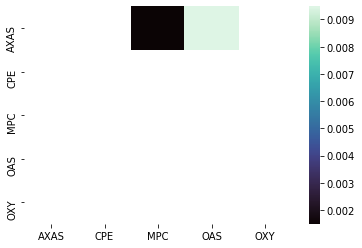

In [3]:
def test_cointegration(financial_information):
    number_of_assets = financial_information.shape[1]
    score_matrix = np.zeros((number_of_assets, number_of_assets))
    p_value_matrix = np.ones((number_of_assets, number_of_assets))
    keys = financial_information.keys()
    pairs = []
    for asset in range(number_of_assets):
        for possible_cointegrated_asset in range(asset + 1, number_of_assets):
            asset_1 = financial_information[keys[asset]]
            asset_2 = financial_information[keys[possible_cointegrated_asset]]
            cointegration_test_result = coint(asset_1, asset_2)
            score = cointegration_test_result[0]
            p_value = cointegration_test_result[1]
            score_matrix[asset, possible_cointegrated_asset] = score
            p_value_matrix[asset, possible_cointegrated_asset] = p_value
            if p_value < 0.01:
                pairs.append((keys[asset], keys[possible_cointegrated_asset]))
        return score_matrix, p_value_matrix, pairs
    
scores, p_values, pairs = test_cointegration(financial_information)
seaborn.heatmap(p_values, xticklabels = financial_information.columns, yticklabels = financial_information.columns, cmap = 'mako', mask = (p_values >= 0.01))

# Trading Strategy

In our corrintegration analysis we have found that AXAS and MPC, and AXAS and OXY are possible pairs with cointegrated priceses, which means that we can use either MPC or OXY in order to calculate a predicted trend for AXAS, for the following example we will use MPC. Knowing this we can go ahead and use our knowledge of cointegration to device a price prediction strategy. For this one in partícular we will use $z-values$ which tell us how many standar deviantiosns away from the mean a value is. This values are calculated as follows.

$Z = \frac{x - \mu}{\sigma}$

Where:

$ Z = $ standard score

$ x = $ observed value

$ \mu = $ mean of the sample

$ \sigma = $ standard deviantion of the sample

This $z-values$ will help us assess the endency of the stock in the following way, if the $z-value > 1$ the asset's price will fall, but if $z-value < -1$ the asset's price will rise. This is due to the mean reverting secuence we will create by substracting MPC from AXAS, if the observed value is far below the mean, we know it will have to rise in order to keep up with its pair, and the opposite willl happen if the observed value is considerably higher than the mean, it will have to fall in order to revert to the average.

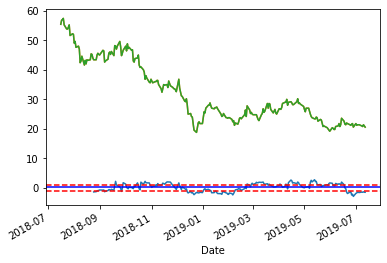

In [4]:
normalization = financial_information['AXAS'] - financial_information['MPC'] 

normalization_moving_average_1 = normalization.rolling(1).mean()
normalization_moving_average_30 = normalization.rolling(30).mean()
normalization_standar_deviation_30 = normalization.rolling(30).std()

z_values = (normalization_moving_average_1-normalization_moving_average_30)/normalization_standar_deviation_30

z_values.plot(label = 'Rolling 20 day z score')
financial_information['AXAS'].plot(label = 'Stock 2')
plt.axhline(z_values.mean(), color = 'b')
plt.axhline(1.0, color = 'r', ls = '--')
plt.axhline(-1.0, color = 'r', ls = '--')

financial_information['AXAS'].plot(label = 'Stock 2')

# Testing

In order to test this trading algorith, we will select a span of about 100 days, and will for each of these evaluate weather the stock price will rise, fall or remain in the gray area where we can't really predict much.

In [7]:
testing_information = yf.download('AXAS', start = '2019-02-17', end = '2019-07-14')
testing_information = testing_information['Close']
print(testing_information.shape)

start_date = datetime.date(2019, 2,17)
end_date = datetime.date(2019, 7,14)
delta = timedelta(days=1)

success = 0
failure = 0
hedge = 0
previous_day = datetime.date(2019, 2,17)

while start_date < end_date:
    try:
        if ((testing_information[start_date.strftime('%Y-%m-%d')] >= testing_information[previous_day.strftime('%Y-%m-%d')]) and (z_values[start_date.strftime('%Y-%m-%d')] <= -1)):
            success = success + 1
        elif (testing_information[start_date.strftime('%Y-%m-%d')] <= testing_information[previous_day.strftime('%Y-%m-%d')]) and (z_values[start_date.strftime('%Y-%m-%d')] >= 1):
            success = success + 1
        elif (-1 < z_values[start_date.strftime('%Y-%m-%d')] < 1):
            hedge = hedge + 1
    except KeyError:
        pass
        
    previous_day = start_date
    start_date += delta
    failure = testing_information.shape[0] - success - hedge

print(f'Success = {success + hedge}, failure = {failure}, total = {testing_information.shape[0]}, acc = {(success + hedge)*100/testing_information.shape[0]}' )

[*********************100%***********************]  1 of 1 completed
(101,)
Success = 58, failure = 43, total = 101, acc = 57.42574257425743


# Limitation

By doing this, we have learned that pairs trading is a rather good method for price prediction, but it has a very disticnt limitation, there is no haw of accurately predicting price behaviour long-term. This is due to our inhability to predict the $z-values$ in the long-term, in orther to do this we would need to incorporate machine learning elemts to this algorithm. For the moment, we can conclude that pair-trading is a very useful way of predicting short-term rises and falls.

Furthermore, while testing we have come to the conclusion that in this particular case, it is a rather uneffective trading method, this is probably because of the cointegration test, since the acceptance criteria is slightly loose, but in the current world-wide circumstances, it has been monstly impossible to find a more closely cointegrated pair. Additionaly, the chosen stock remain rather close to the mean trough the selected time period, making many of the dates not complete succeses because peirs trading relays on this mean-reverting behaviour to predict, which means that a considerable amount of the results are correct, but not useful.